In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Explanation:
# In this script, we demonstrate how adding more data can help mitigate overfitting.
# We create a larger synthetic dataset plus our original thermometer readings,
# then split into training and validation sets, train a simple linear model,
# and plot the results. We'll reference Figure 4.13-like scenarios for overfitting.


In [2]:
torch.manual_seed(123)  # For reproducibility

# We create synthetic data points for t_u (unknown units) in [0, 80]
N = 30
t_u_synth = 80.0 * torch.rand(N)

# A linear relationship with some noise: t_c_synth = 0.5 * t_u_synth - 10 + noise
t_c_synth = 0.5 * t_u_synth - 10.0 + torch.randn(N) * 2.0

# Original thermometer data from the book example
t_c_orig = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0])
t_u_orig = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

# Combine synthetic and original data
t_u_combined = torch.cat([t_u_synth, t_u_orig])
t_c_combined = torch.cat([t_c_synth, t_c_orig])

print("Total data points:", t_u_combined.shape[0])


Total data points: 41


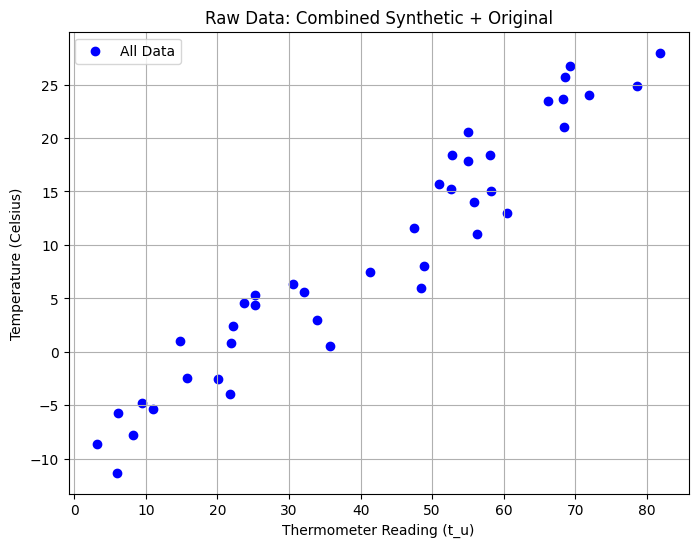

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(t_u_combined.numpy(), t_c_combined.numpy(), color='blue', label='All Data')
plt.xlabel("Thermometer Reading (t_u)")
plt.ylabel("Temperature (Celsius)")
plt.title("Raw Data: Combined Synthetic + Original")
plt.legend()
plt.grid(True)
plt.show()

# Explanation:
# The scatter plot shows both synthetic data (which is roughly linear with noise)
# and the original thermometer data from the book example.


In [4]:
def model(t_u, w, b):
    """
    Linear model: predicted Celsius = w * t_u + b
    """
    return w * t_u + b

def loss_fn(t_p, t_c):
    """
    Mean Squared Error (MSE) Loss: average((t_p - t_c)^2)
    """
    return ((t_p - t_c)**2).mean()


In [5]:
n_samples = t_u_combined.shape[0]
n_val = int(0.2 * n_samples)  # 20% validation
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices   = shuffled_indices[-n_val:]

train_t_u = t_u_combined[train_indices]
train_t_c = t_c_combined[train_indices]
val_t_u   = t_u_combined[val_indices]
val_t_c   = t_c_combined[val_indices]

# Normalize input by multiplying by 0.01 to keep gradient steps small
train_t_un = 0.01 * train_t_u
val_t_un   = 0.01 * val_t_u

print(f"Training samples: {train_t_un.shape[0]}, Validation samples: {val_t_un.shape[0]}")


Training samples: 33, Validation samples: 8


In [11]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    """
    Train a linear model while monitoring both training and validation losses.
    """
    train_losses = []
    val_losses   = []
    for epoch in range(1, n_epochs+1):
        # Forward pass on training data
        train_t_p = model(train_t_u, params[0], params[1])
        train_loss = loss_fn(train_t_p, train_t_c)
        train_losses.append(train_loss.item())
        
        # Forward pass on validation data (no backward pass)
        val_t_p = model(val_t_u, params[0], params[1])
        val_loss = loss_fn(val_t_p, val_t_c)
        val_losses.append(val_loss.item())

        
        assert not val_loss.requires_grad, "val_loss should not require grad."
        
        # Backprop on training loss only
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # Print progress
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch:4d}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}")
    
    return params, train_losses, val_losses


In [7]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)


In [8]:
print("=== Training with More Data ===")
n_epochs = 3000
trained_params, train_losses, val_losses = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    params=params,
    train_t_u=train_t_un,
    val_t_u=val_t_un,
    train_t_c=train_t_c,
    val_t_c=val_t_c
)

print("Trained Parameters:", trained_params.detach().numpy())


=== Training with More Data ===
Epoch    1, Training loss 160.9725, Validation loss 317.2536
Epoch    2, Training loss 157.8044, Validation loss 311.3318
Epoch    3, Training loss 154.7751, Validation loss 305.6188
Epoch  500, Training loss 48.7220, Validation loss 69.4078
Epoch 1000, Training loss 27.7653, Validation loss 34.8693
Epoch 1500, Training loss 18.1818, Validation loss 19.0079
Epoch 2000, Training loss 13.7992, Validation loss 11.7091
Epoch 2500, Training loss 11.7950, Validation loss 8.3405
Epoch 3000, Training loss 10.8786, Validation loss 6.7794
Trained Parameters: [42.80893  -8.546278]


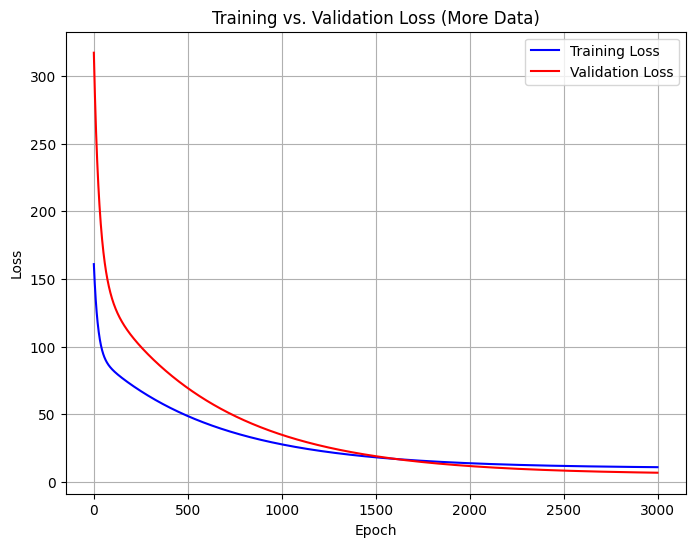

In [9]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses,   label='Validation Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss (More Data)")
plt.legend()
plt.grid(True)
plt.show()

# Explanation of figure:
# Referencing something like Figure 4.13:
#  - If both curves decrease and stay close, the model is likely generalizing well (case C or D).
#  - If they diverge, it's overfitting (case B).
#  - If neither decreases, the model is not learning (case A).


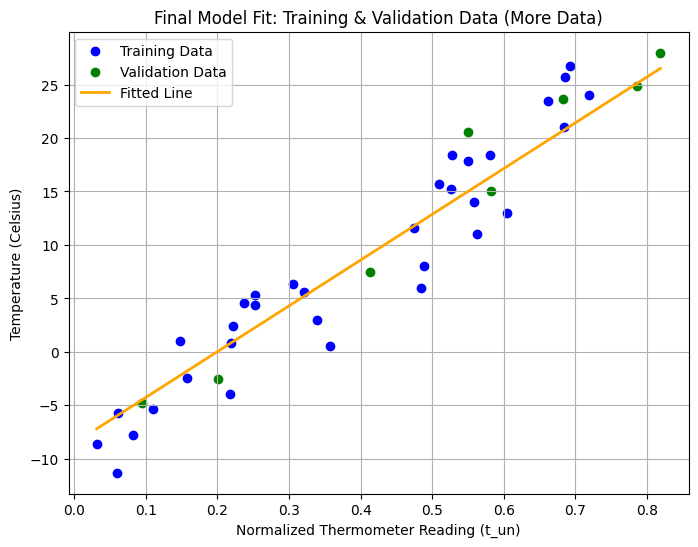

In [10]:
# We'll create a range of t_u values for a smooth fitted line
t_u_range = torch.linspace(t_u_combined.min(), t_u_combined.max(), 100)
t_un_range = 0.01 * t_u_range

with torch.no_grad():
    t_p_range = model(t_un_range, trained_params[0], trained_params[1])

plt.figure(figsize=(8,6))
# Plot training data
plt.scatter(train_t_un.numpy(), train_t_c.numpy(), color='blue', label='Training Data')
# Plot validation data
plt.scatter(val_t_un.numpy(),   val_t_c.numpy(),   color='green', label='Validation Data')
# Plot fitted line
plt.plot(t_un_range.numpy(), t_p_range.numpy(), color='orange', linewidth=2, label='Fitted Line')
plt.xlabel("Normalized Thermometer Reading (t_un)")
plt.ylabel("Temperature (Celsius)")
plt.title("Final Model Fit: Training & Validation Data (More Data)")
plt.legend()
plt.grid(True)
plt.show()

# Explanation:
# With more data, the model is less likely to overfit. If the training and validation
# losses remain close, that indicates better generalization. By referencing Figure 4.13:
#  - We hope to see a scenario resembling case C or D (good or acceptable generalization).
#
# End of Script